[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kili-technology/kili-playground/blob/feature/3315-5-aau-on-playground-when-i-look-at-active-learning-i-see-a-recipe-using-cifar100-and-different-modal-algorithms/recipes/active-learning/cifar100.ipynb)

In [1]:
!pip install skorch
!pip install modAL
!git clone https://github.com/kili-technology/kili-playground/ \
            -b feature/3315-5-aau-on-playground-when-i-look-at-active-learning-i-see-a-recipe-using-cifar100-and-different-modal-algorithms
!git clone https://github.com/weiaicunzai/pytorch-cifar100

     |████████████████████████████████| 122kB 3.5MB/s 
Cloning into 'kili-playground'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 3463 (delta 12), reused 8 (delta 2), pack-reused 3432
Receiving objects: 100% (3463/3463), 60.49 MiB | 37.52 MiB/s, done.
Resolving deltas: 100% (2200/2200), done.
Cloning into 'pytorch-cifar100'...
remote: Enumerating objects: 759, done.
remote: Total 759 (delta 0), reused 0 (delta 0), pack-reused 759
Receiving objects: 100% (759/759), 447.26 KiB | 4.26 MiB/s, done.
Resolving deltas: 100% (454/454), done.


In [0]:
import logging
from functools import partial

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

__import__('kili-playground')

import numpy as np
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import *
from torchvision.datasets import *

from modAL.models import *
from modAL.uncertainty import *
from modAL.disagreement import *
from modAL.batch import *

In [0]:
class LinearBottleNeck(nn.Module):

    def __init__(self, in_channels, out_channels, stride, t=6, class_num=100):
        super().__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, 1),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, in_channels * t, 3, stride=stride, padding=1, groups=in_channels * t),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
    
    def forward(self, x):

        residual = self.residual(x)

        if self.stride == 1 and self.in_channels == self.out_channels:
            residual += x
        
        return residual

class MobileNetV2(nn.Module):

    def __init__(self, class_num=100):
        super().__init__()

        self.pre = nn.Sequential(
            nn.Conv2d(3, 32, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.stage1 = LinearBottleNeck(32, 16, 1, 1)
        self.stage2 = self._make_stage(2, 16, 24, 2, 6)
        self.stage3 = self._make_stage(3, 24, 32, 2, 6)
        self.stage4 = self._make_stage(4, 32, 64, 2, 6)
        self.stage5 = self._make_stage(3, 64, 96, 1, 6)
        self.stage6 = self._make_stage(3, 96, 160, 1, 6)
        self.stage7 = LinearBottleNeck(160, 320, 1, 6)

        self.conv1 = nn.Sequential(
            nn.Conv2d(320, 1280, 1),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.conv2 = nn.Conv2d(1280, class_num, 1)
            
    def forward(self, x):
        x = self.pre(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        return x
    
    def _make_stage(self, repeat, in_channels, out_channels, stride, t):

        layers = []
        layers.append(LinearBottleNeck(in_channels, out_channels, stride, t))
        
        while repeat - 1:
            layers.append(LinearBottleNeck(out_channels, out_channels, 1, t))
            repeat -= 1
        
        return nn.Sequential(*layers)

def mobilenetv2():
    return MobileNetV2(class_num=10)

In [0]:
# build class for the skorch API
class Torch_Model(nn.Module):
    def __init__(self,):
        super(Torch_Model, self).__init__()
        self.convs = nn.Sequential(
                                nn.Conv2d(1,32,3),
                                nn.ReLU(),
                                nn.Conv2d(32,64,3),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                nn.Dropout(0.25)
        )
        self.fcs = nn.Sequential(
                                nn.Linear(12*12*64,128),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(128,10),
        )

    def forward(self, x):
        out = x
        out = self.convs(out)
        out = out.view(-1,12*12*64)
        out = self.fcs(out)
        return out
    
class CustomSkorch(NeuralNetClassifier):

    def __init__(self, fit_method='fit_partial', *args, **kwargs):
        super(CustomSkorch, self).__init__(*args, **kwargs)
        self.fit_method = fit_method
    
    def fit(self, *args):
        if self.fit_method == 'fit_partial':
            return super().partial_fit(*args)
        else:
            return super().fit(*args)

In [0]:
# create the classifier
device = "cuda" if torch.cuda.is_available() else "cpu"
def get_model(dataset):
    verbose = 0
    if dataset == 'CIFAR':
        return CustomSkorch(module=mobilenetv2,
                                    criterion=nn.CrossEntropyLoss,
                                    optimizer=torch.optim.Adam,
                                    train_split=None,
                                    verbose=verbose,
                                    device=device,
                                    lr=1e-3,
                                    max_epochs=5)
    elif dataset == 'MNIST':
        return CustomSkorch(module=Torch_Model,
                                    criterion=nn.CrossEntropyLoss,
                                    optimizer=torch.optim.Adam,
                                    train_split=None,
                                    verbose=verbose,
                                    device=device,
                                    lr=1e-3,
                                    max_epochs=5)
    else:
        raise ValueError(f'{dataset} dataset unknown')

In [0]:
def getTestPoolData(X, y, n_train, n_test, n_pool, n_initial=1000):
    assert X.shape[0] > n_test + n_train
    
    X_train, X_test, y_train, y_test = X[:n_train], X[n_train:n_train+n_test], y[:n_train], y[n_train:n_train+n_test]
    X_train = X_train.reshape(n_train, *X.shape[1:])
    X_test = X_test.reshape(n_test, *X.shape[1:])

    # assemble initial data
    initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
    X_initial = X_train[initial_idx]
    y_initial = y_train[initial_idx]

    # generate the pool
    # remove the initial data from the training dataset
    X_pool = np.delete(X_train, initial_idx, axis=0)[:n_pool]
    y_pool = np.delete(y_train, initial_idx, axis=0)[:n_pool]
    return X_pool, y_pool, X_test, y_test, X_initial, y_initial

In [11]:
CIFAR100_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
CIFAR100_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

transform_train = transforms.Compose([
        #transforms.ToPILImage(),
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(15),
        transforms.ToTensor(),
        # transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
transform_test = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# cifar100_train = torchvision.datasets.CIFAR100(root='.', train=False, download=True, transform=transform_train)
# cifar100_test = torchvision.datasets.CIFAR100(root='.', train=False, download=True, transform=transform_test)
cifar100_train = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform_train)
cifar100_test = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform_test)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [0]:
dataloader = DataLoader(cifar100_train, shuffle=True, batch_size=10000)
X, y = next(iter(dataloader))

In [20]:
mnist_data = MNIST('.', download=True, transform=ToTensor())
dataloader = DataLoader(mnist_data, shuffle=True, batch_size=60000)
X, y = next(iter(dataloader))

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw





Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
n_train = 6000; n_test = 3000; n_pool = 5000
# n_train = 50000; n_test = 10000; n_pool = 5000
X_pool, y_pool, X_test, y_test, X_initial, y_initial = getTestPoolData(X, y, n_train, n_test, n_pool)

In [0]:
def random_sampling(classifier, X, n_instances=100, *args, **kwargs):
    query_idx = np.random.choice(X.shape[0], size=n_instances, replace=False)
    return query_idx, X[query_idx]

In [0]:
def evaluate_strategy(strategy, verbose=False, n_queries=10,
                      samples_per_queries=100, dataset='CIFAR',
                      strategy_type='uncertainty'):
    print(f'Testing strategy {strategy.__name__}')
    if strategy_type == 'uncertainty':
        classifier = get_model(dataset)
        learner = ActiveLearner(
            estimator=classifier,
            X_training=X_initial, y_training=y_initial,
            query_strategy=strategy
        )
    elif strategy_type == 'disagreement':
        n = 3
        learners = [ActiveLearner(
            estimator=get_model(dataset),
            X_training=X_initial, y_training=y_initial,
            query_strategy=strategy) for _ in range(5)]
        learner = Committee(
            learner_list=learners,
            query_strategy=strategy
        )

    X_local, y_local = X_pool.clone(), y_pool.clone()
    init_score = learner.score(X_test, y_test)
    performances = [init_score]
    if verbose: print(f'Initial score {init_score:.2%}')
    
    for idx in tqdm(range(n_queries)):
        query_idx, query_instance = learner.query(X_local, n_instances=100)
        learner.teach(
            X=X_local[query_idx], y=y_local[query_idx], only_new=False,
        )
        X_local = np.delete(X_local, query_idx, axis=0)
        y_local = np.delete(y_local, query_idx, axis=0)
        score = learner.score(X_test, y_test)
        performances.append(score)
        if verbose: print(f'Score : {score:.2%}')
    return performances

In [16]:
uncertainty_strategies = [
    (random_sampling, 'uncertainty'),
    # (entropy_sampling, 'uncertainty'),
    # (margin_sampling, 'uncertainty'),
    (uncertainty_sampling, 'uncertainty'),
    # (max_disagreement_sampling, 'disagreement'),
    # (consensus_entropy_sampling, 'disagreement'),
    (vote_entropy_sampling, 'disagreement'),
    (uncertainty_batch_sampling, 'uncertainty')
]

strat2perf = {}
for strategy, strat_type in uncertainty_strategies:
    name = strategy.__name__
    perf = evaluate_strategy(strategy, verbose=False, n_queries=5,
                             dataset='CIFAR', strategy_type=strat_type)
    strat2perf[name] = perf

Testing strategy random_sampling


100%|██████████| 5/5 [18:25<00:00, 221.12s/it]


Testing strategy uncertainty_sampling


100%|██████████| 5/5 [20:47<00:00, 249.40s/it]


Testing strategy vote_entropy_sampling


100%|██████████| 5/5 [1:41:19<00:00, 1215.86s/it]


Testing strategy uncertainty_batch_sampling


100%|██████████| 5/5 [33:17<00:00, 399.41s/it]


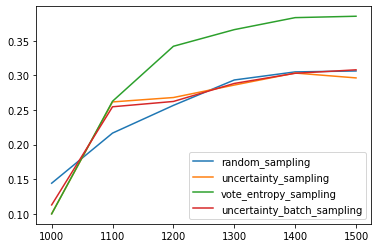

In [19]:
import matplotlib.pyplot as plt
N_labels = [1000] + [1000 + 100*i for i in range(1, 6)]
plt.figure()
for strat, perf in strat2perf.items():
    plt.plot(N_labels, perf, label=strat)
plt.legend()

In [22]:
uncertainty_strategies = [
    (random_sampling, 'uncertainty'),
    # (entropy_sampling, 'uncertainty'),
    # (margin_sampling, 'uncertainty'),
    (uncertainty_sampling, 'uncertainty'),
    # (max_disagreement_sampling, 'disagreement'),
    # (consensus_entropy_sampling, 'disagreement'),
    (vote_entropy_sampling, 'disagreement'),
    (uncertainty_batch_sampling, 'uncertainty')
]

strat2perf = {}
for strategy, strat_type in uncertainty_strategies:
    name = strategy.__name__
    perf = evaluate_strategy(strategy, verbose=False, n_queries=10, samples_per_queries=300,
                             dataset='MNIST', strategy_type=strat_type)
    strat2perf[name] = perf

Testing strategy random_sampling


100%|██████████| 10/10 [02:55<00:00, 17.59s/it]


Testing strategy uncertainty_sampling


100%|██████████| 10/10 [03:31<00:00, 21.17s/it]


Testing strategy vote_entropy_sampling


100%|██████████| 10/10 [17:50<00:00, 107.08s/it]


Testing strategy uncertainty_batch_sampling


100%|██████████| 10/10 [11:28<00:00, 68.88s/it]


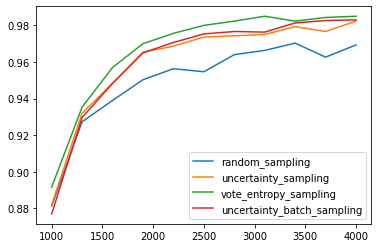

In [23]:
N_labels = [1000] + [1000 + 300*i for i in range(1, 11)]
plt.figure()
for strat, perf in strat2perf.items():
    plt.plot(N_labels, perf, label=strat)
plt.legend()